In [1]:
%reset

In [1]:
from datamaker_f import VideoDataGenerator
from pipeline_f import build_full_model
import pickle
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from io import BytesIO
from PIL import Image
import pandas as pd
import numpy as np
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
# Load the dataset from the pickle file
with open("D:/Projects/Face-Swap-Detection-Model/video_data_2600_001.pkl", "rb") as f:
    pickled_data = pickle.load(f)

In [4]:
# Print the structure of one sample entry
sample_video = list(pickled_data.keys())[0]  # Take the first video folder as an example
print(f"Sample video '{sample_video}' structure:")
print("Frames count:", len(pickled_data[sample_video]['frames']))
print("Frames labels count:", len(pickled_data[sample_video]['frames_label']))
print("Micro-expression count:", len(pickled_data[sample_video]['Micro_Expression']))
print("Micro-expression labels count:", len(pickled_data[sample_video]['Micro_Expression_label']))

Sample video '000' structure:
Frames count: 395
Frames labels count: 395
Micro-expression count: 1185
Micro-expression labels count: 1185


In [5]:
# Convert your video_data dictionary to a list of items for easier splitting
data_items = list(pickled_data.items())
video_names, labels = zip(*[(video_name, video_info['frames_label'][0]) for video_name, video_info in pickled_data.items()])

In [6]:
# Split the data
train_names, test_names, train_labels, test_labels = train_test_split(video_names, labels, test_size=0.3, random_state=42)
train_names, val_names, train_labels, val_labels = train_test_split(train_names, train_labels, test_size=0.2, random_state=44)

In [7]:
# Prepare dictionaries for each split
train_data = {name: pickled_data[name] for name in train_names}
val_data = {name: pickled_data[name] for name in val_names}
test_data = {name: pickled_data[name] for name in test_names}

In [8]:
#length of train and test data
print(len(train_data))
print(len(val_data))
print(len(test_data))

1491
373
799


In [9]:
# Define the output signature for the generator
output_signature = (
    (
        tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32)
    ),
    tf.TensorSpec(shape=(None,1), dtype=tf.float32)
)

train_generator = tf.data.Dataset.from_generator(
    lambda: VideoDataGenerator(train_data),
    output_signature=output_signature
)


val_generator = tf.data.Dataset.from_generator(
    lambda: VideoDataGenerator(val_data),
    output_signature=output_signature
)

test_generator = tf.data.Dataset.from_generator(
    lambda: VideoDataGenerator(test_data),
    output_signature=output_signature
)

X_frames shape: (16, 224, 224, 3)
X_micro_exp shape: (16, 64, 64, 3)
y shape: (16, 1)


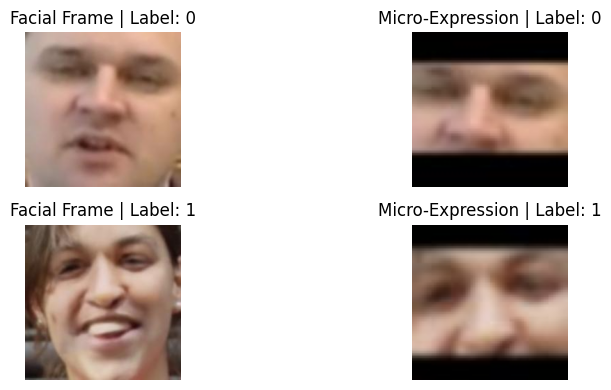

In [10]:
import matplotlib.pyplot as plt

# Initialize flags to track if we've found samples of each class
found_label_0 = False
found_label_1 = False

# Take a batch and unpack it
for batch in train_generator.take(1):
    (X_frames, X_micro_exp), y = batch

    # Print the shapes to verify
    print(f"X_frames shape: {X_frames.shape}")
    print(f"X_micro_exp shape: {X_micro_exp.shape}")
    print(f"y shape: {y.shape}")

    # Loop through the batch to find examples of both labels
    for sample_index in range(len(y)):
        sample_label = int(y[sample_index].numpy()[0])  # Assuming binary classification

        # Check if we already have examples for each label
        if sample_label == 0 and not found_label_0:
            found_label_0 = True
            sample_frame_0 = X_frames[sample_index].numpy().astype("uint8")
            sample_micro_exp_0 = X_micro_exp[sample_index].numpy().astype("uint8")

        elif sample_label == 1 and not found_label_1:
            found_label_1 = True
            sample_frame_1 = X_frames[sample_index].numpy().astype("uint8")
            sample_micro_exp_1 = X_micro_exp[sample_index].numpy().astype("uint8")

        # Break loop once we have both examples
        if found_label_0 and found_label_1:
            break

# Display images for both labels
plt.figure(figsize=(10, 4))

# Display facial and micro-expression frames for label 0
plt.subplot(2, 2, 1)
plt.imshow(sample_frame_0)
plt.title("Facial Frame | Label: 0")
plt.axis("off")

plt.subplot(2, 2, 2)
plt.imshow(sample_micro_exp_0)
plt.title("Micro-Expression | Label: 0")
plt.axis("off")

# Display facial and micro-expression frames for label 1
plt.subplot(2, 2, 3)
plt.imshow(sample_frame_1)
plt.title("Facial Frame | Label: 1")
plt.axis("off")

plt.subplot(2, 2, 4)
plt.imshow(sample_micro_exp_1)
plt.title("Micro-Expression | Label: 1")
plt.axis("off")

plt.tight_layout()
plt.show()


In [11]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    verbose=1,
    min_lr=5e-6
)

In [12]:
optimizer_2 = Adam(learning_rate=1e-4)

In [13]:
model_2 = build_full_model()

In [14]:
model_2.compile(
    optimizer=optimizer_2,
    loss="mean_squared_logarithmic_error",
    metrics=["accuracy"]
)

In [15]:
history_2 = model_2.fit(
    train_generator,
    validation_data=val_generator,
    epochs=60,
    callbacks=[early_stopping, lr_scheduler]
)

Epoch 1/60


94/94 [==============================] - 458s 4s/step - loss: 0.2511 - accuracy: 0.5459 - val_loss: 0.1679 - val_accuracy: 0.6649 - lr: 1.0000e-04
Epoch 2/60
94/94 [==============================] - 234s 2s/step - loss: 0.1990 - accuracy: 0.6653 - val_loss: 0.1621 - val_accuracy: 0.7882 - lr: 1.0000e-04
Epoch 3/60
94/94 [==============================] - 225s 2s/step - loss: 0.1567 - accuracy: 0.7975 - val_loss: 0.2649 - val_accuracy: 0.5737 - lr: 1.0000e-04
Epoch 4/60
94/94 [==============================] - 221s 2s/step - loss: 0.1386 - accuracy: 0.8410 - val_loss: 0.1693 - val_accuracy: 0.7882 - lr: 1.0000e-04
Epoch 5/60
94/94 [==============================] - 218s 2s/step - loss: 0.1278 - accuracy: 0.8692 - val_loss: 0.1397 - val_accuracy: 0.8472 - lr: 1.0000e-04
Epoch 6/60
94/94 [==============================] - 213s 2s/step - loss: 0.1157 - accuracy: 0.9054 - val_loss: 0.1461 - val_accuracy: 0.8418 - lr: 1.0000e-04
Epoch 7/60
94/94 [==============================] 

In [16]:
test_loss, test_accuracy = model_2.evaluate(test_generator)
print(f"Test loss: {test_loss}, Test accuracy: {test_accuracy}")

50/50 [==============================] - 33s 652ms/step - loss: 0.0854 - accuracy: 0.9374
Test loss: 0.08541622757911682, Test accuracy: 0.9374217987060547


In [18]:
model_2.save("model_2_acc_9375_011124.h5")

c:\Users\USER\anaconda3\envs\Face-Swap-Detection-Model\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [19]:
model_2.save_weights("model_2_weights_011124_acc_9375.h5")

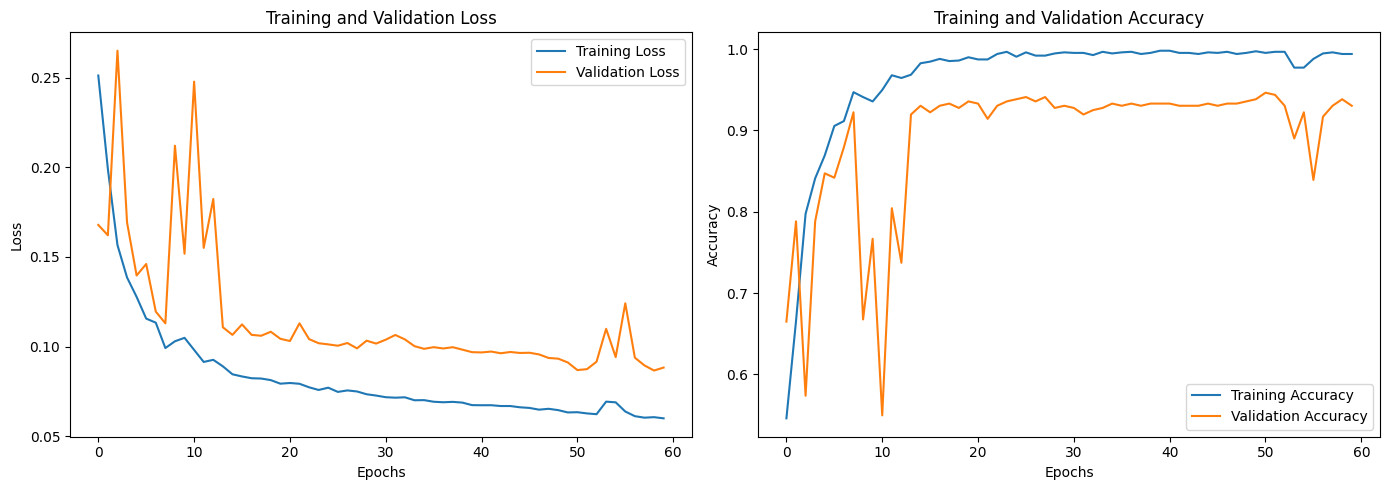

In [20]:
import matplotlib.pyplot as plt

# Plot loss and accuracy for training and validation sets
def plot_history(history):
    # Loss plot
    plt.figure(figsize=(14, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plotting the history of model_2
plot_history(history_2)


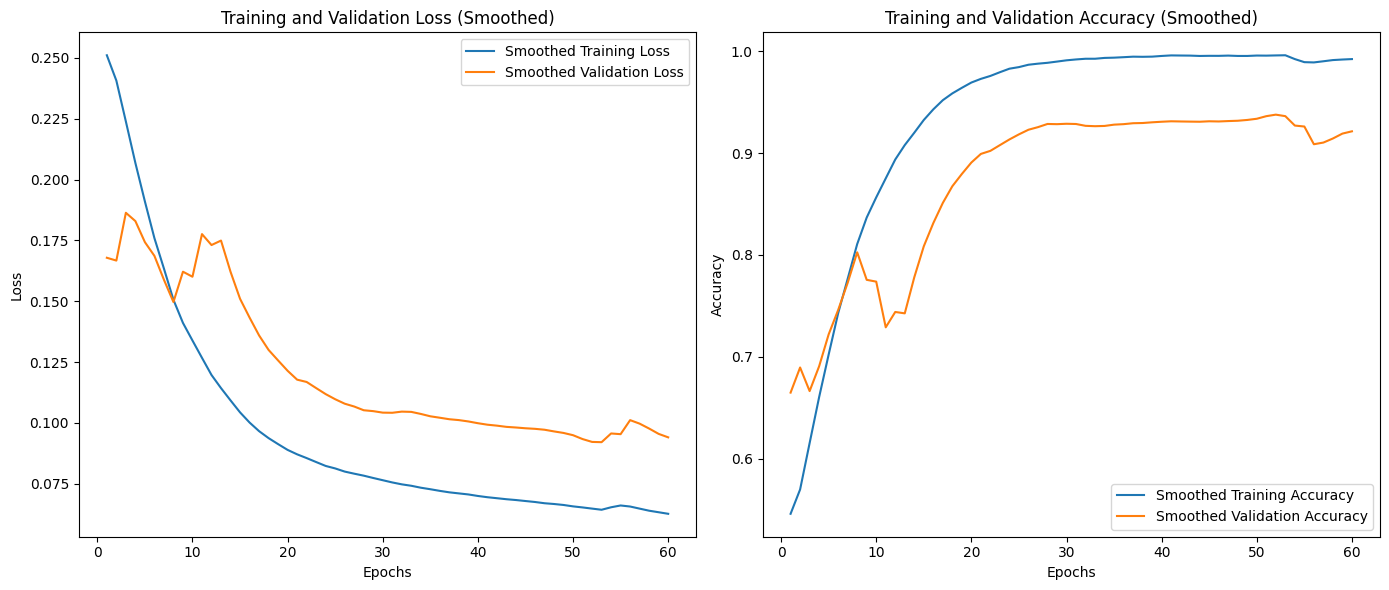

In [17]:
import matplotlib.pyplot as plt
import numpy as np

def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            smoothed_points.append(smoothed_points[-1] * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

# Plot with smoothing
def plot_history(history):
    epochs = range(1, len(history.history['loss']) + 1)
    
    plt.figure(figsize=(14, 6))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, smooth_curve(history.history['loss']), label='Smoothed Training Loss')
    plt.plot(epochs, smooth_curve(history.history['val_loss']), label='Smoothed Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss (Smoothed)')
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, smooth_curve(history.history['accuracy']), label='Smoothed Training Accuracy')
    plt.plot(epochs, smooth_curve(history.history['val_accuracy']), label='Smoothed Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy (Smoothed)')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history_2)


In [22]:
# Extract true labels from the test generator
y_true = np.concatenate([y for _, y in test_generator], axis=0)

In [23]:
test_prediction = model_2.predict(test_generator)

test_prediction_labels = np.argmax(test_prediction, axis=1)

50/50 [==============================] - 35s 701ms/step


In [26]:
# Calculate ROC-AUC Score
from sklearn.metrics import roc_auc_score


roc_auc = roc_auc_score(y_true, test_prediction)
print(f"ROC-AUC Score: {roc_auc:.4f}")

ROC-AUC Score: 0.9786


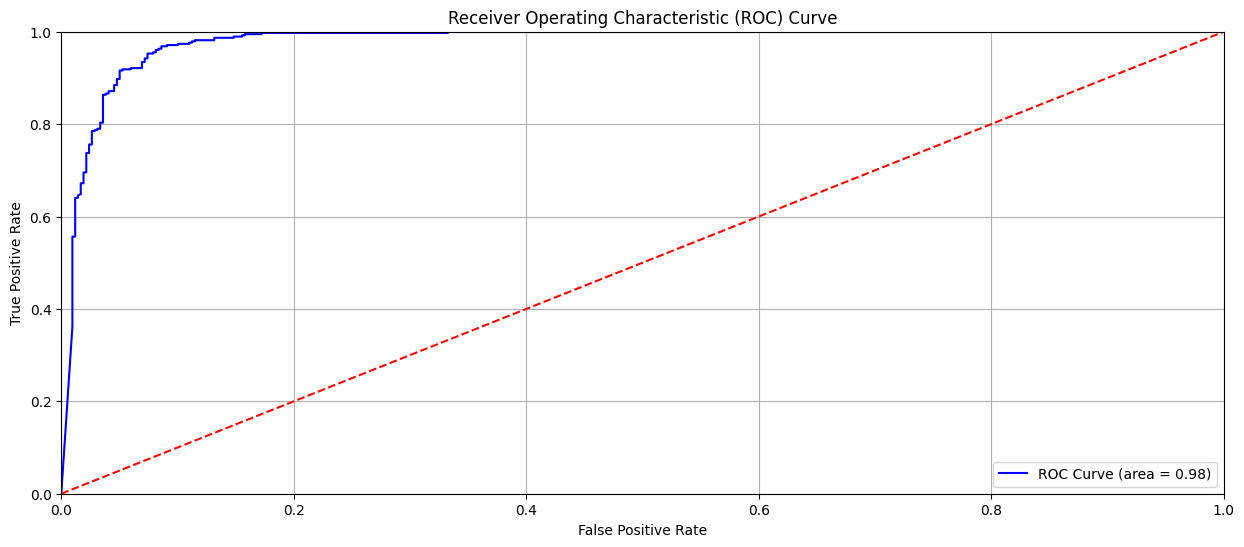

In [37]:
# Calculate ROC curve
from sklearn.metrics import roc_curve


fpr, tpr, thresholds = roc_curve(y_true, test_prediction)

# Plot ROC curve
plt.figure(figsize=(15, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

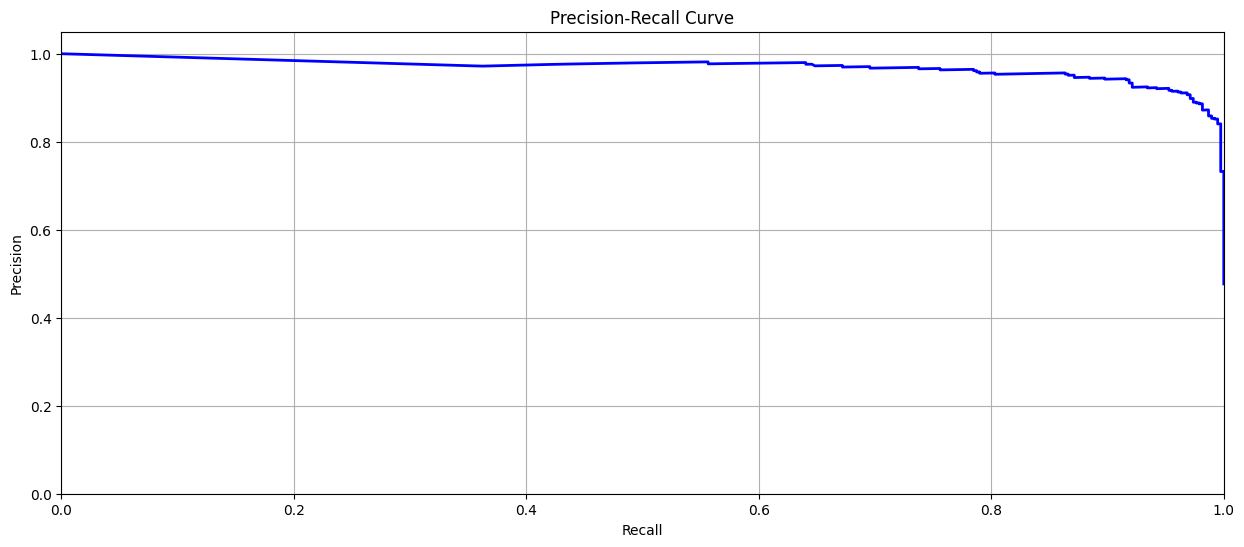

In [36]:
from sklearn.metrics import precision_recall_curve

# Calculate precision and recall
precision, recall, _ = precision_recall_curve(y_true, test_prediction)

# Plotting the Precision-Recall curve
plt.figure(figsize=(15, 6))
plt.plot(recall, precision, color='blue', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid()
plt.show()

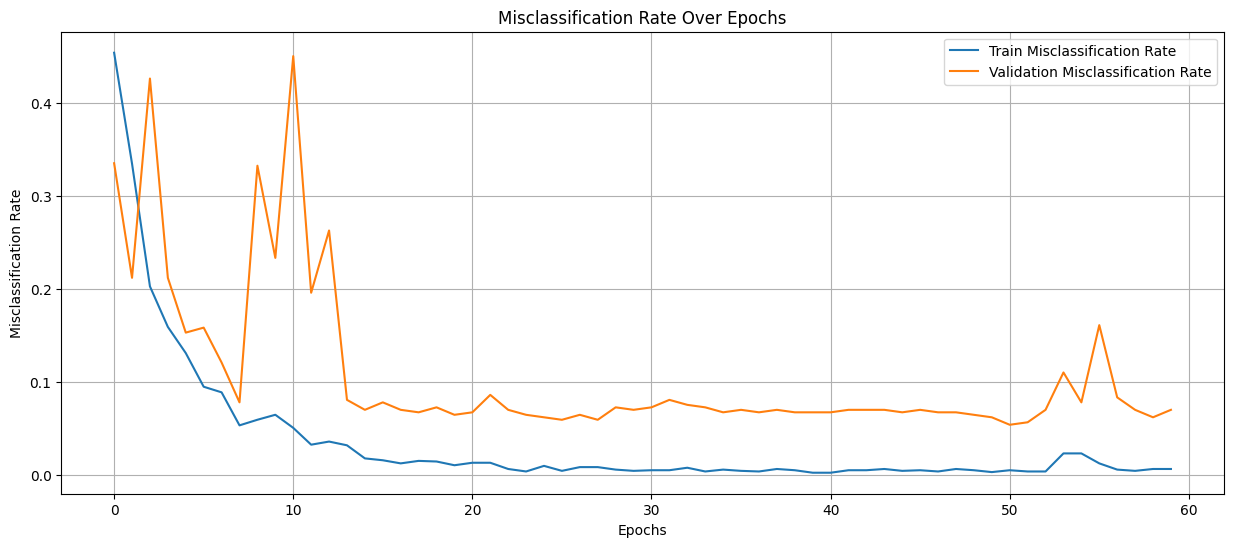

In [34]:
# Misclassification rate for train and validation data
train_misclassification = [1 - acc for acc in history_2.history['accuracy']]
val_misclassification = [1 - val_acc for val_acc in history_2.history['val_accuracy']]

# Plot misclassification rates
plt.figure(figsize=(15, 6))
plt.plot(train_misclassification, label='Train Misclassification Rate')
plt.plot(val_misclassification, label='Validation Misclassification Rate')
plt.xlabel('Epochs')
plt.ylabel('Misclassification Rate')
plt.title('Misclassification Rate Over Epochs')
plt.legend()
plt.grid(True)
plt.show()


In [47]:
# save the history
with open('history_2.pkl', 'wb') as f:
    pickle.dump(history_2.history, f)

In [4]:
# load the history
with open('../../saved/history_model_011124_acc_93.pkl', 'rb') as f:
    history_2 = pickle.load(f)

In [5]:
history_2.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

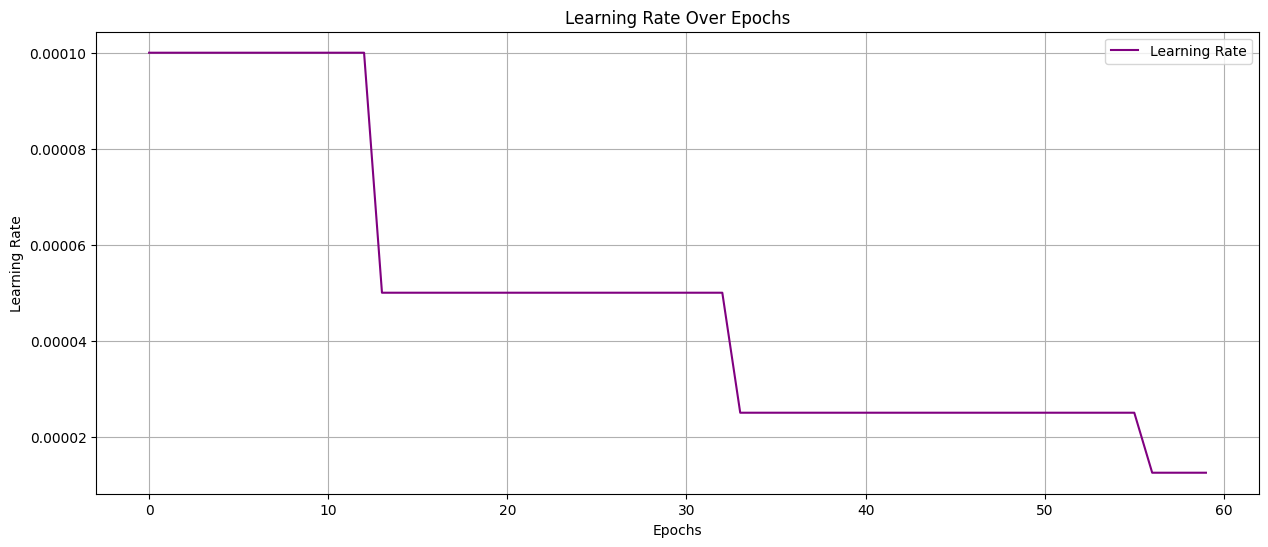

In [8]:
plt.figure(figsize=(15, 6))
plt.plot(history_2['lr'], label='Learning Rate', color='purple')
plt.title('Learning Rate Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()


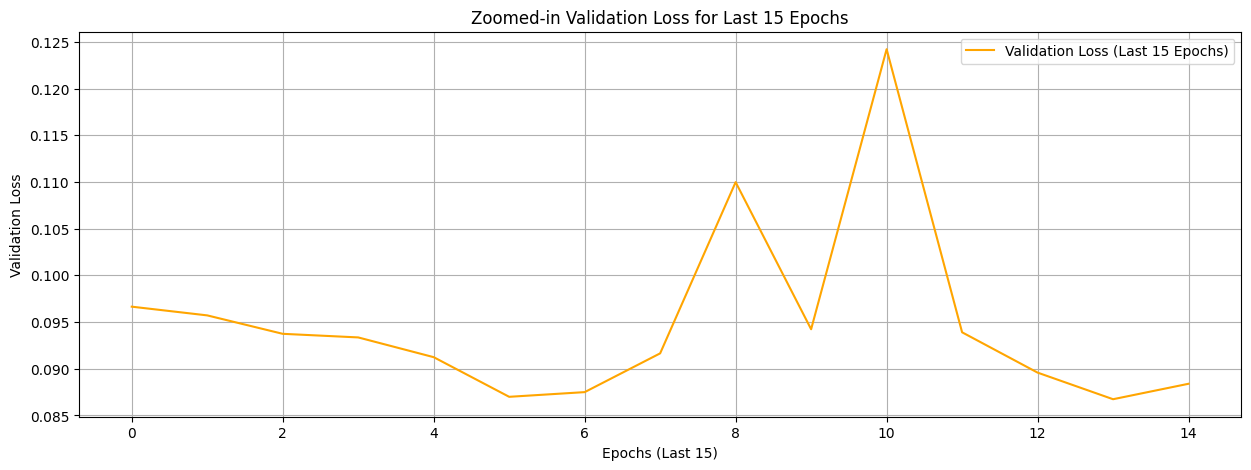

In [ ]:
# Assuming the last 10 epochs for zoom-in
plt.figure(figsize=(15, 5))
plt.plot(history_2['val_loss'][-15:], label='Validation Loss (Last 15 Epochs)', color='orange')
plt.title('Zoomed-in Validation Loss for Last 15 Epochs')
plt.xlabel('Epochs (Last 15)')
plt.ylabel('Validation Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()


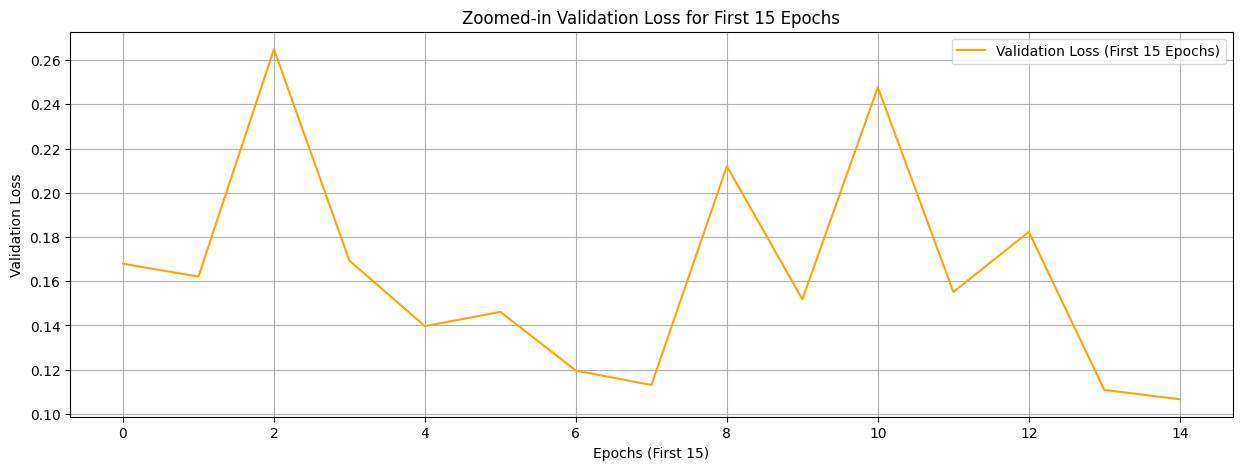

In [19]:
# Assuming the last 10 epochs for zoom-in
plt.figure(figsize=(15, 5))
plt.plot(history_2['val_loss'][0:15], label='Validation Loss (First 15 Epochs)', color='orange')
plt.title('Zoomed-in Validation Loss for First 15 Epochs')
plt.xlabel('Epochs (First 15)')
plt.ylabel('Validation Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()


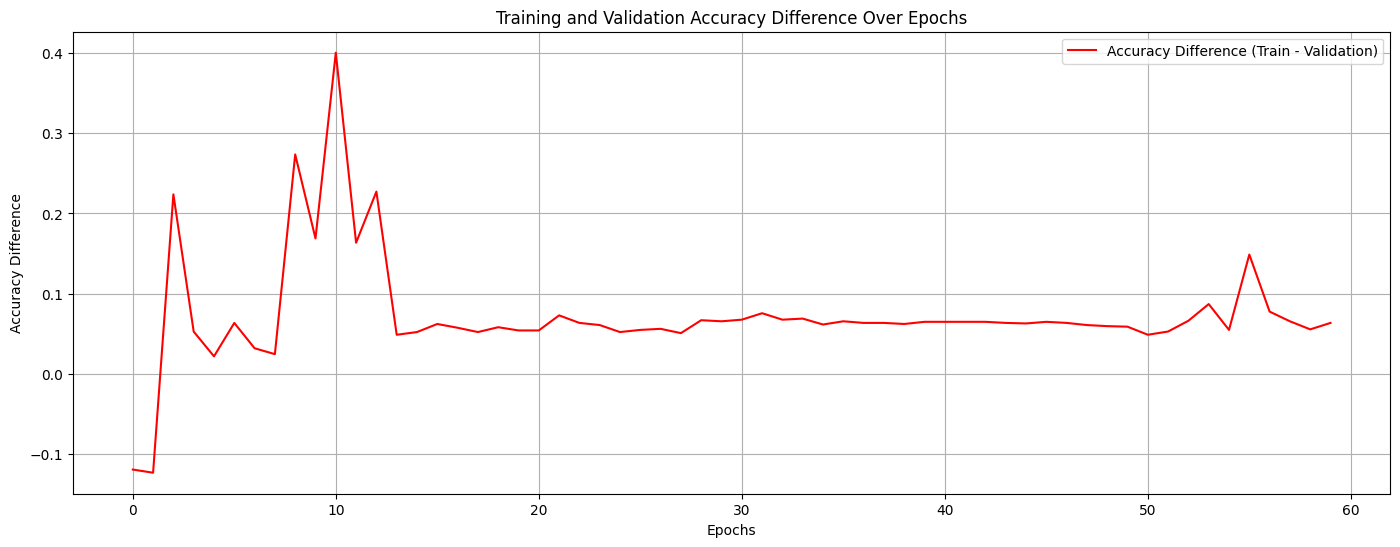

In [21]:
plt.figure(figsize=(17, 6))
accuracy_diff = np.array(history_2['accuracy']) - np.array(history_2['val_accuracy'])
plt.plot(accuracy_diff, label='Accuracy Difference (Train - Validation)', color='red')
plt.title('Training and Validation Accuracy Difference Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy Difference')
plt.legend()
plt.grid(True)
plt.show()


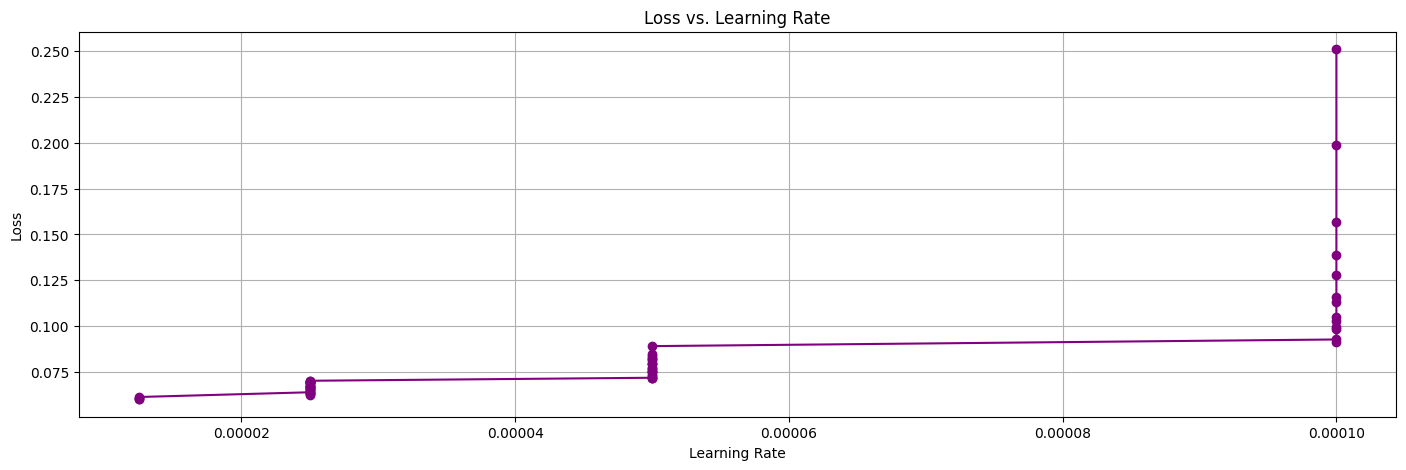

In [22]:
plt.figure(figsize=(17, 5))
plt.plot(history_2['lr'], history_2['loss'], marker='o', color='purple')
plt.title('Loss vs. Learning Rate')
plt.xlabel('Learning Rate')
plt.ylabel('Loss')
plt.grid(True)
plt.show()


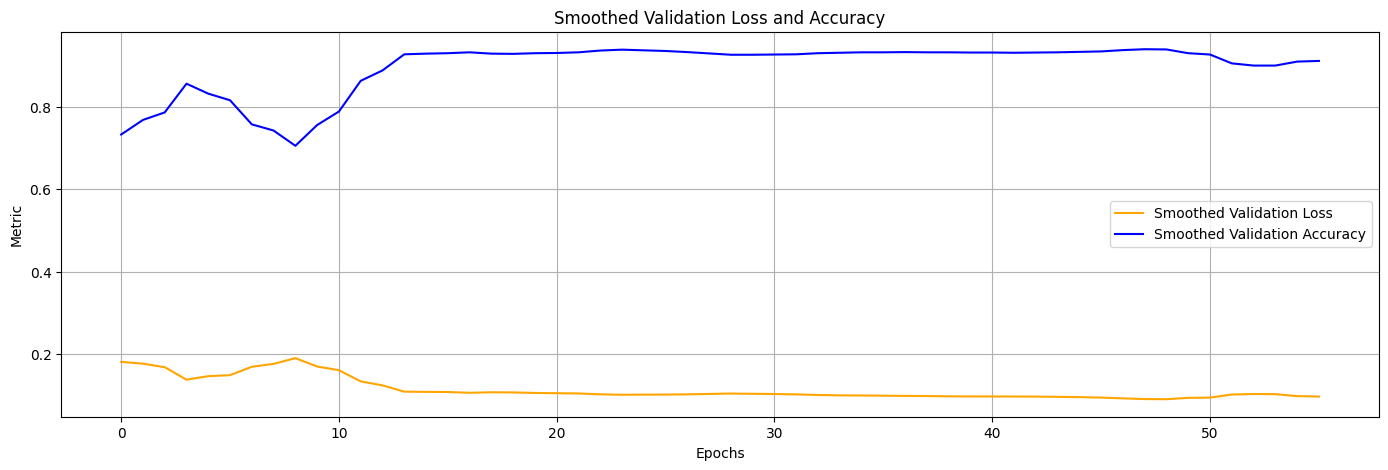

In [23]:
def moving_average(data, window_size=3):
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')

plt.figure(figsize=(17, 5))
plt.plot(moving_average(history_2['val_loss'], 5), label='Smoothed Validation Loss', color='orange')
plt.plot(moving_average(history_2['val_accuracy'], 5), label='Smoothed Validation Accuracy', color='blue')
plt.title('Smoothed Validation Loss and Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Metric')
plt.legend()
plt.grid(True)
plt.show()


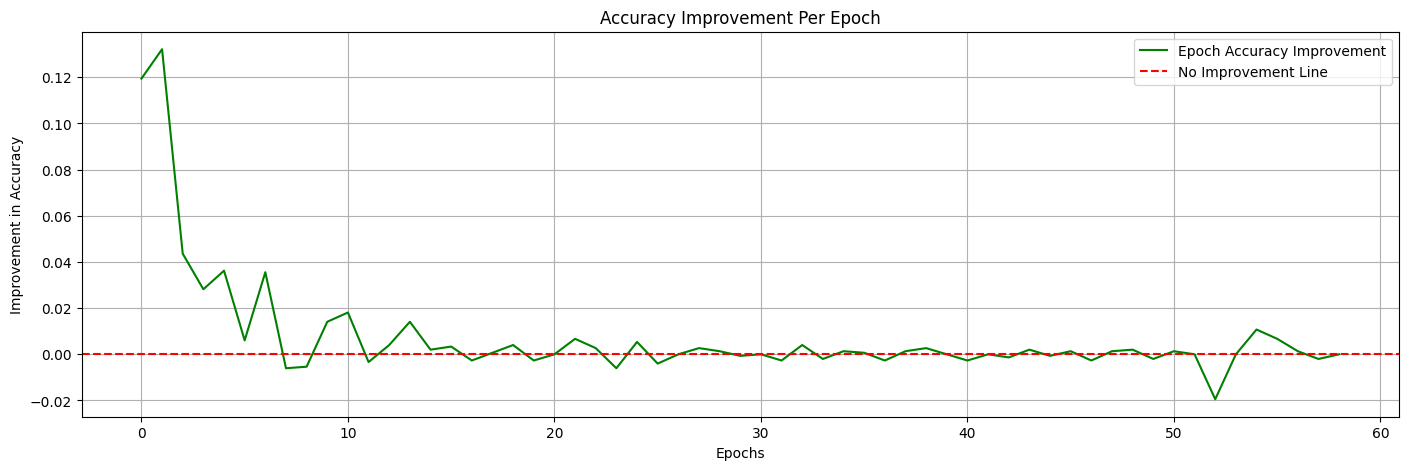

In [24]:
epoch_accuracy_improvement = np.diff(history_2['accuracy'])
plt.figure(figsize=(17, 5))
plt.plot(epoch_accuracy_improvement, label='Epoch Accuracy Improvement', color='green')
plt.axhline(0, color='red', linestyle='--', label='No Improvement Line')
plt.title('Accuracy Improvement Per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Improvement in Accuracy')
plt.legend()
plt.grid(True)
plt.show()


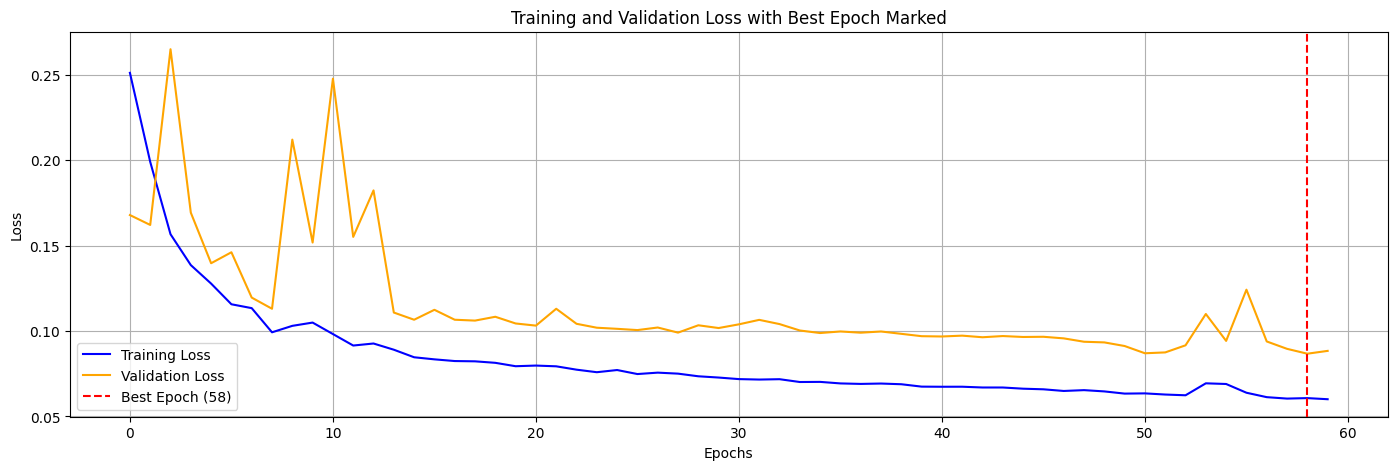

In [25]:
best_epoch = np.argmin(history_2['val_loss'])

plt.figure(figsize=(17, 5))
plt.plot(history_2['loss'], label='Training Loss', color='blue')
plt.plot(history_2['val_loss'], label='Validation Loss', color='orange')
plt.axvline(best_epoch, color='red', linestyle='--', label=f'Best Epoch ({best_epoch})')
plt.title('Training and Validation Loss with Best Epoch Marked')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


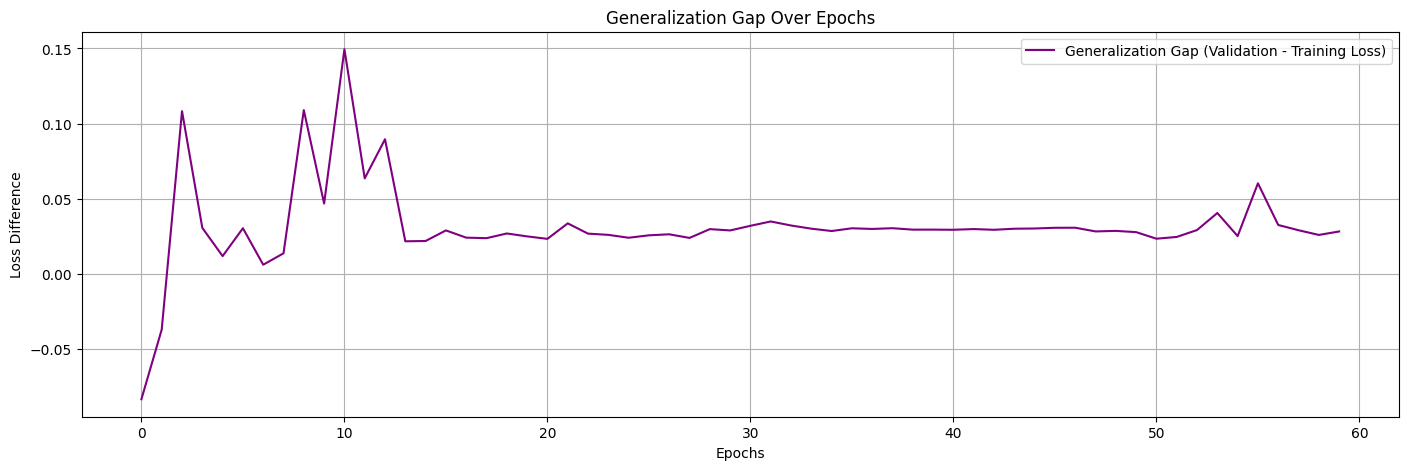

In [26]:
plt.figure(figsize=(17, 5))
generalization_gap = np.array(history_2['val_loss']) - np.array(history_2['loss'])
plt.plot(generalization_gap, color='purple', label='Generalization Gap (Validation - Training Loss)')
plt.title('Generalization Gap Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss Difference')
plt.legend()
plt.grid(True)
plt.show()


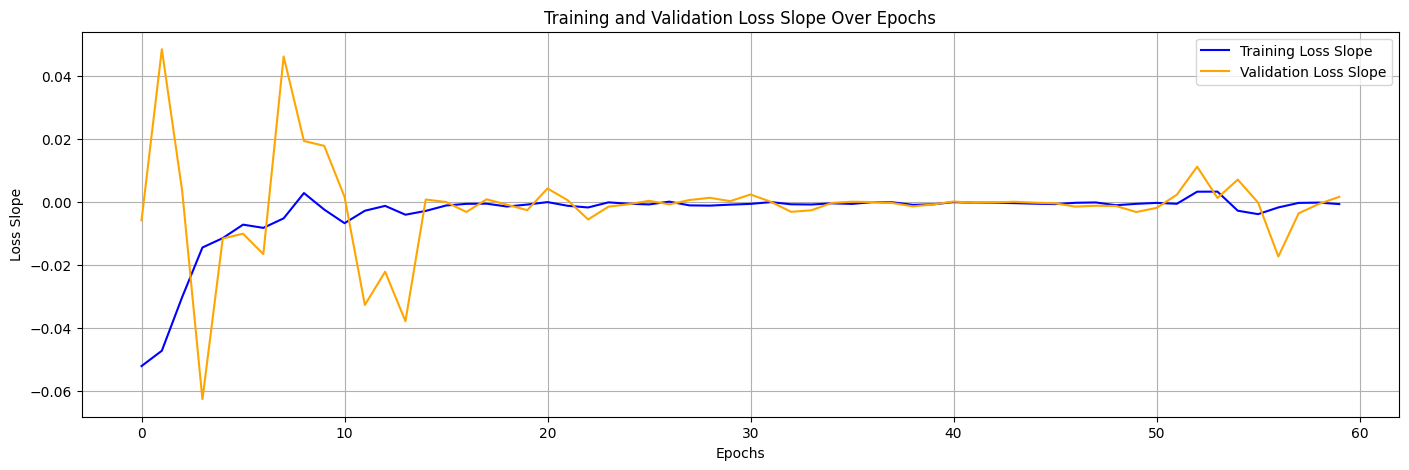

In [28]:
training_loss_slope = np.gradient(history_2['loss'])
validation_loss_slope = np.gradient(history_2['val_loss'])

plt.figure(figsize=(17, 5))
plt.plot(training_loss_slope, label='Training Loss Slope', color='blue')
plt.plot(validation_loss_slope, label='Validation Loss Slope', color='orange')
plt.title('Training and Validation Loss Slope Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss Slope')
plt.legend()
plt.grid(True)
plt.show()


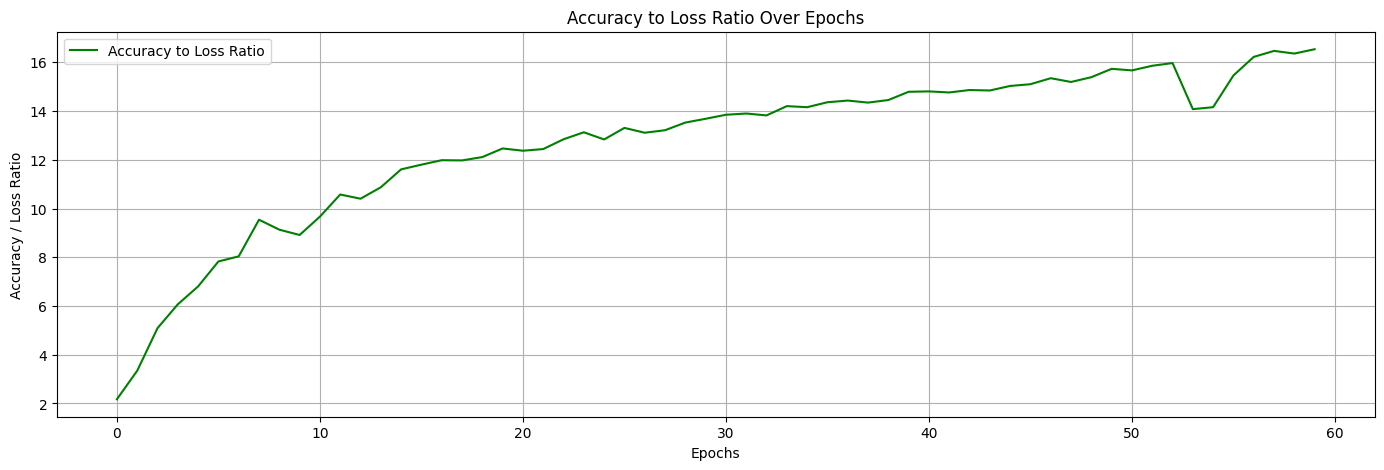

In [29]:
accuracy_loss_ratio = np.array(history_2['accuracy']) / (np.array(history_2['loss']) + 1e-8)
plt.figure(figsize=(17, 5))
plt.plot(accuracy_loss_ratio, color='green', label='Accuracy to Loss Ratio')
plt.title('Accuracy to Loss Ratio Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy / Loss Ratio')
plt.legend()
plt.grid(True)
plt.show()


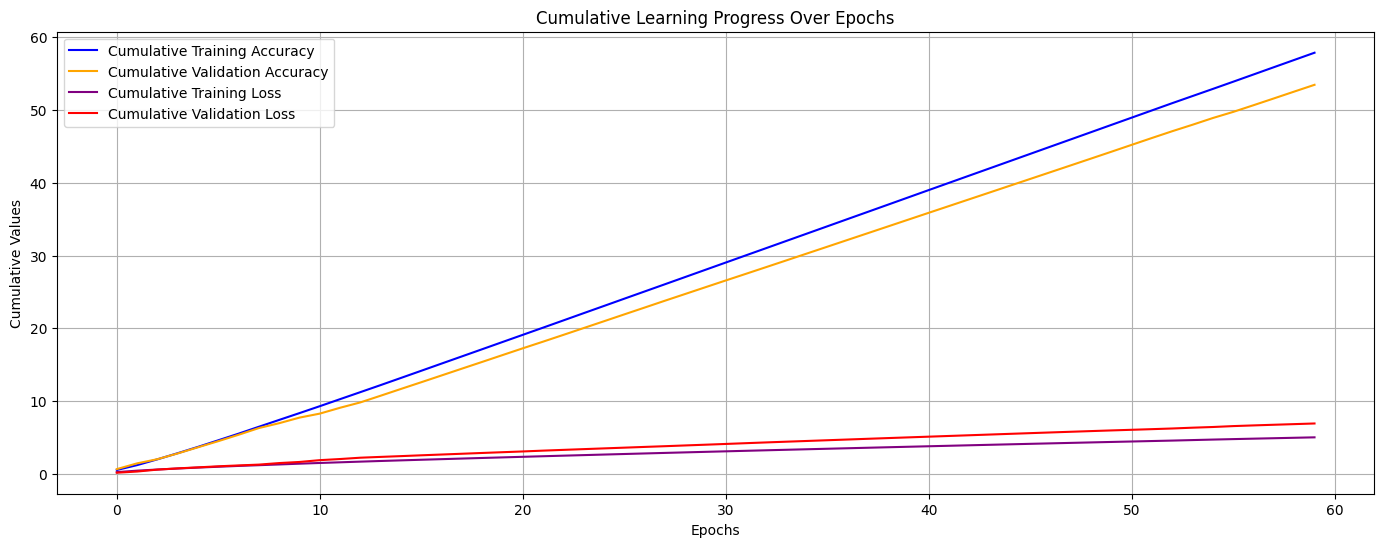

In [30]:
cumulative_accuracy = np.cumsum(history_2['accuracy'])
cumulative_val_accuracy = np.cumsum(history_2['val_accuracy'])
cumulative_loss = np.cumsum(history_2['loss'])
cumulative_val_loss = np.cumsum(history_2['val_loss'])

plt.figure(figsize=(17, 6))
plt.plot(cumulative_accuracy, label='Cumulative Training Accuracy', color='blue')
plt.plot(cumulative_val_accuracy, label='Cumulative Validation Accuracy', color='orange')
plt.plot(cumulative_loss, label='Cumulative Training Loss', color='purple')
plt.plot(cumulative_val_loss, label='Cumulative Validation Loss', color='red')
plt.title('Cumulative Learning Progress Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Cumulative Values')
plt.legend()
plt.grid(True)
plt.show()


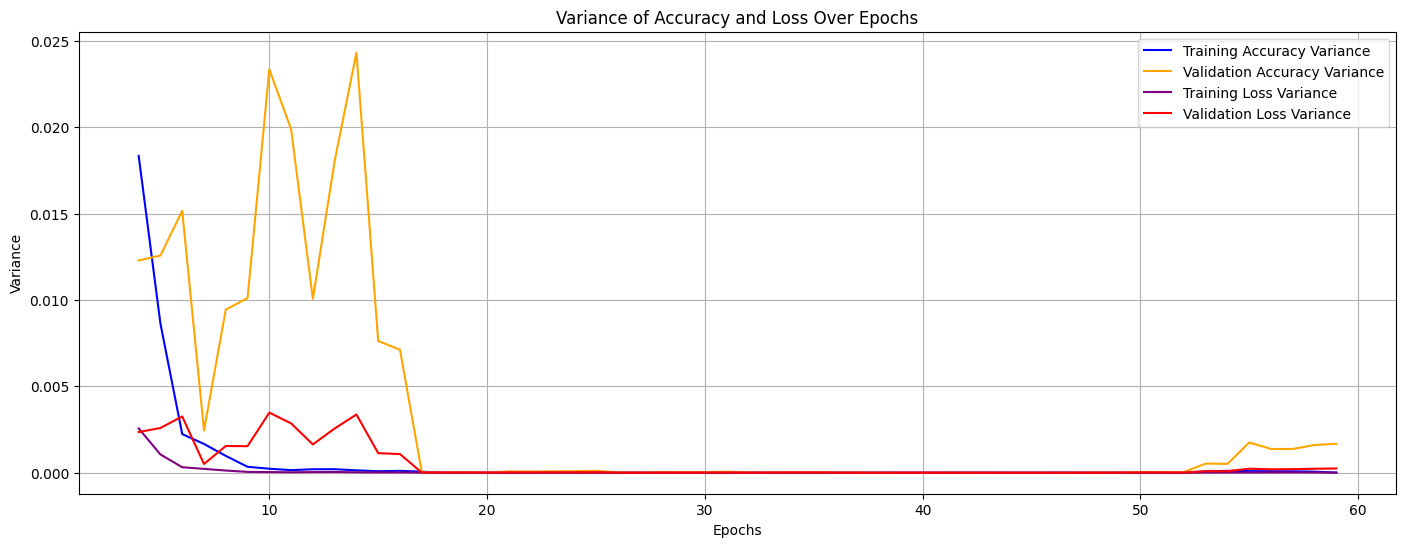

In [31]:
window_size = 5  # Adjust this based on your preferences
accuracy_variance = pd.Series(history_2['accuracy']).rolling(window=window_size).var()
val_accuracy_variance = pd.Series(history_2['val_accuracy']).rolling(window=window_size).var()
loss_variance = pd.Series(history_2['loss']).rolling(window=window_size).var()
val_loss_variance = pd.Series(history_2['val_loss']).rolling(window=window_size).var()

plt.figure(figsize=(17, 6))
plt.plot(accuracy_variance, label='Training Accuracy Variance', color='blue')
plt.plot(val_accuracy_variance, label='Validation Accuracy Variance', color='orange')
plt.plot(loss_variance, label='Training Loss Variance', color='purple')
plt.plot(val_loss_variance, label='Validation Loss Variance', color='red')
plt.title('Variance of Accuracy and Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Variance')
plt.legend()
plt.grid(True)
plt.show()


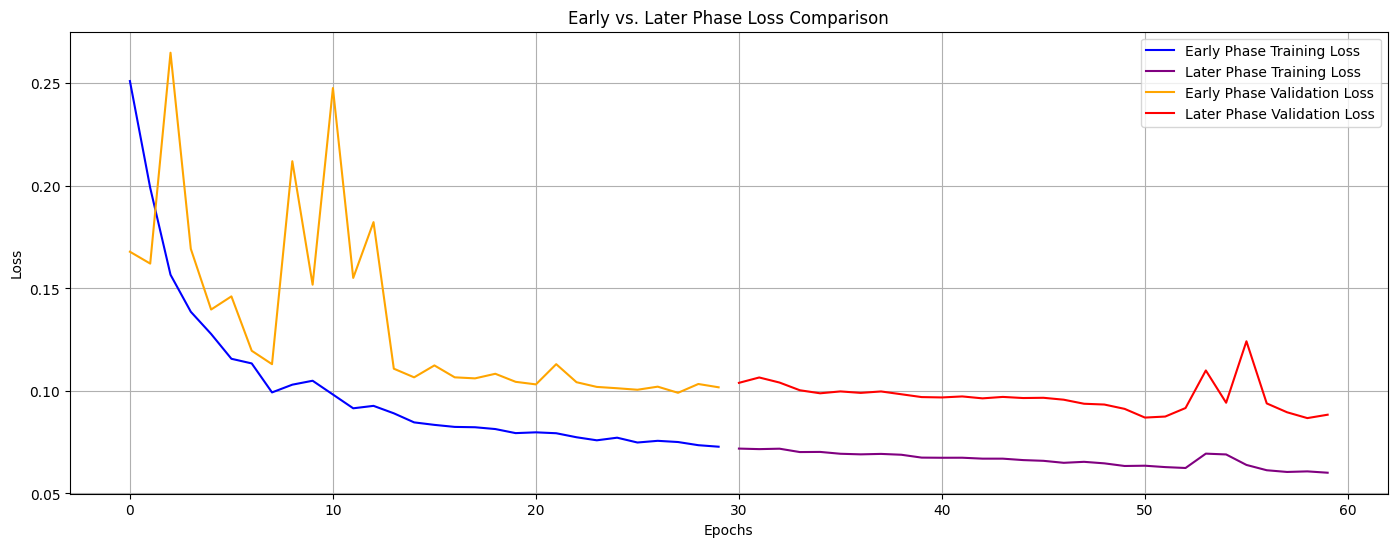

In [32]:
midpoint = len(history_2['loss']) // 2
epochs = list(range(len(history_2['loss'])))

plt.figure(figsize=(17, 6))
plt.plot(epochs[:midpoint], history_2['loss'][:midpoint], label='Early Phase Training Loss', color='blue')
plt.plot(epochs[midpoint:], history_2['loss'][midpoint:], label='Later Phase Training Loss', color='purple')
plt.plot(epochs[:midpoint], history_2['val_loss'][:midpoint], label='Early Phase Validation Loss', color='orange')
plt.plot(epochs[midpoint:], history_2['val_loss'][midpoint:], label='Later Phase Validation Loss', color='red')
plt.title('Early vs. Later Phase Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


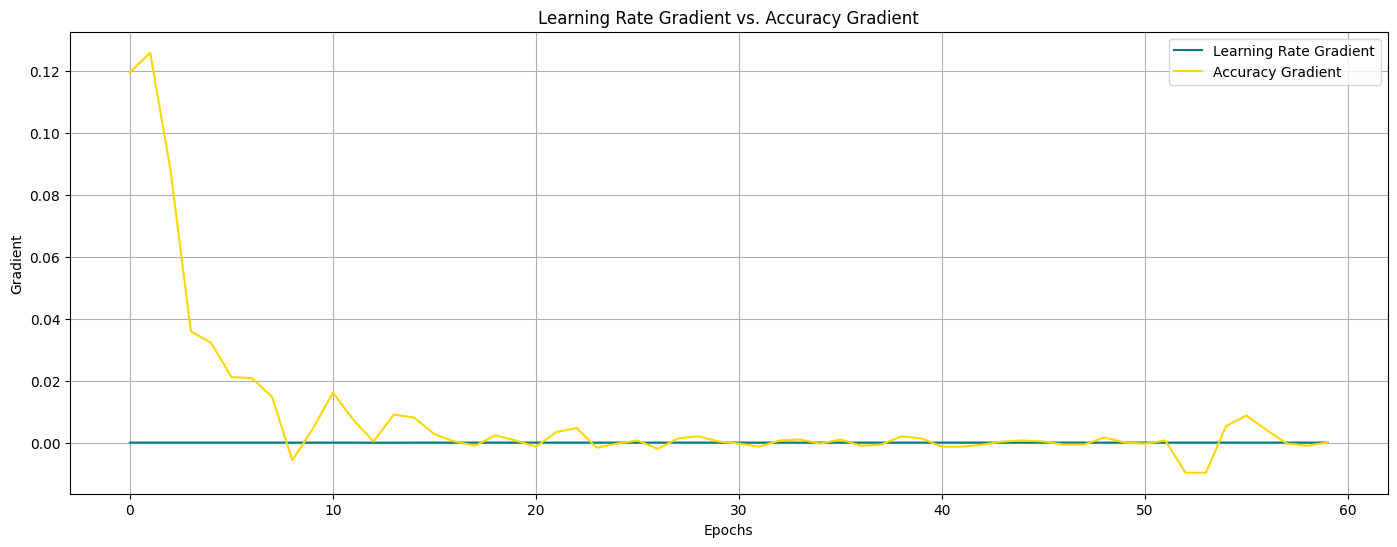

In [33]:
lr_gradient = np.gradient(history_2['lr'])
accuracy_gradient = np.gradient(history_2['accuracy'])

plt.figure(figsize=(17, 6))
plt.plot(lr_gradient, label='Learning Rate Gradient', color='teal')
plt.plot(accuracy_gradient, label='Accuracy Gradient', color='gold')
plt.title('Learning Rate Gradient vs. Accuracy Gradient')
plt.xlabel('Epochs')
plt.ylabel('Gradient')
plt.legend()
plt.grid(True)
plt.show()


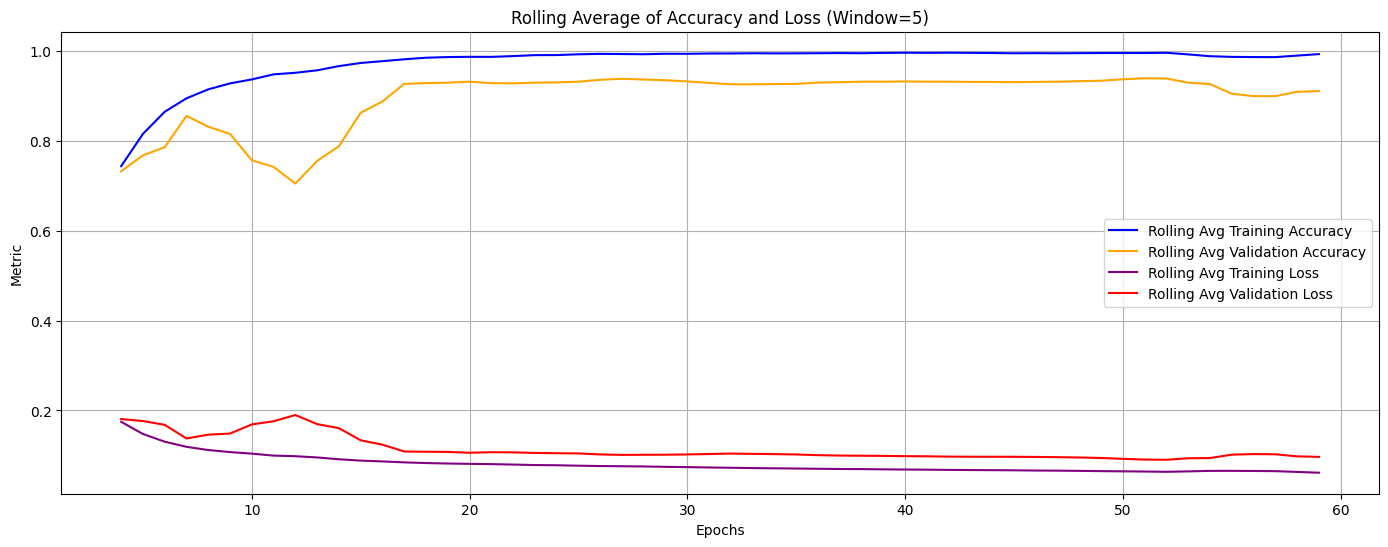

In [34]:
window = 5  # Choose the window size for smoothing

plt.figure(figsize=(17, 6))
plt.plot(pd.Series(history_2['accuracy']).rolling(window=window).mean(), label='Rolling Avg Training Accuracy', color='blue')
plt.plot(pd.Series(history_2['val_accuracy']).rolling(window=window).mean(), label='Rolling Avg Validation Accuracy', color='orange')
plt.plot(pd.Series(history_2['loss']).rolling(window=window).mean(), label='Rolling Avg Training Loss', color='purple')
plt.plot(pd.Series(history_2['val_loss']).rolling(window=window).mean(), label='Rolling Avg Validation Loss', color='red')
plt.title(f'Rolling Average of Accuracy and Loss (Window={window})')
plt.xlabel('Epochs')
plt.ylabel('Metric')
plt.legend()
plt.grid(True)
plt.show()


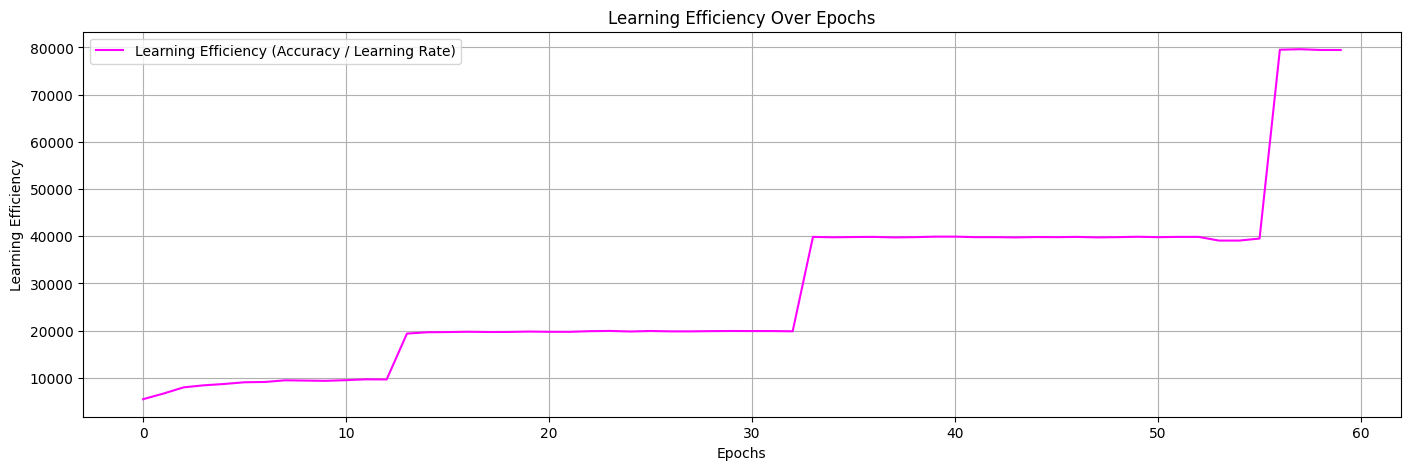

In [35]:
learning_efficiency = np.array(history_2['accuracy']) / (np.array(history_2['lr']) + 1e-8)

plt.figure(figsize=(17, 5))
plt.plot(learning_efficiency, label='Learning Efficiency (Accuracy / Learning Rate)', color='magenta')
plt.title('Learning Efficiency Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Learning Efficiency')
plt.legend()
plt.grid(True)
plt.show()


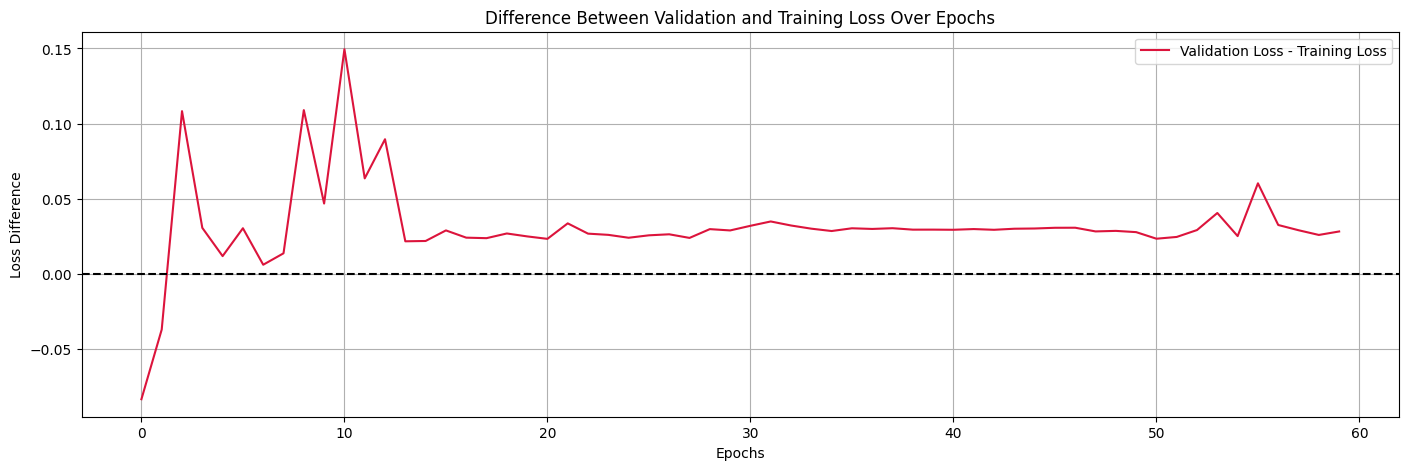

In [36]:
loss_diff = np.array(history_2['val_loss']) - np.array(history_2['loss'])

plt.figure(figsize=(17, 5))
plt.plot(loss_diff, label='Validation Loss - Training Loss', color='crimson')
plt.title('Difference Between Validation and Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss Difference')
plt.axhline(0, color='black', linestyle='--')
plt.legend()
plt.grid(True)
plt.show()


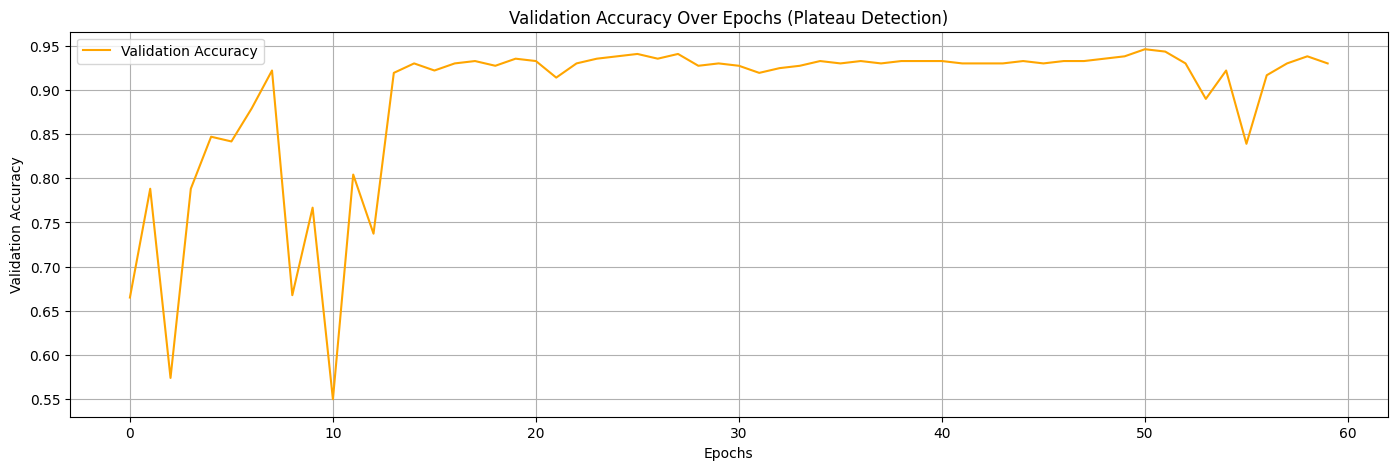

In [37]:
plt.figure(figsize=(17, 5))
plt.plot(history_2['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Validation Accuracy Over Epochs (Plateau Detection)')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()


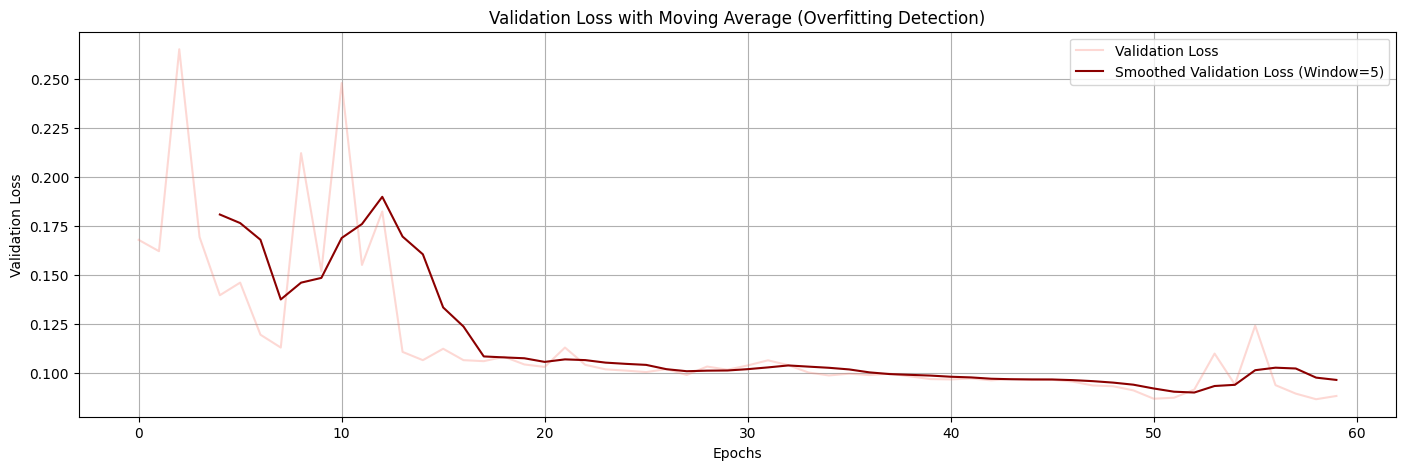

In [38]:
window_size = 5  # Adjust the window for smoothing
val_loss_smooth = pd.Series(history_2['val_loss']).rolling(window=window_size).mean()

plt.figure(figsize=(17, 5))
plt.plot(history_2['val_loss'], label='Validation Loss', color='salmon', alpha=0.3)
plt.plot(val_loss_smooth, label=f'Smoothed Validation Loss (Window={window_size})', color='darkred')
plt.title('Validation Loss with Moving Average (Overfitting Detection)')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


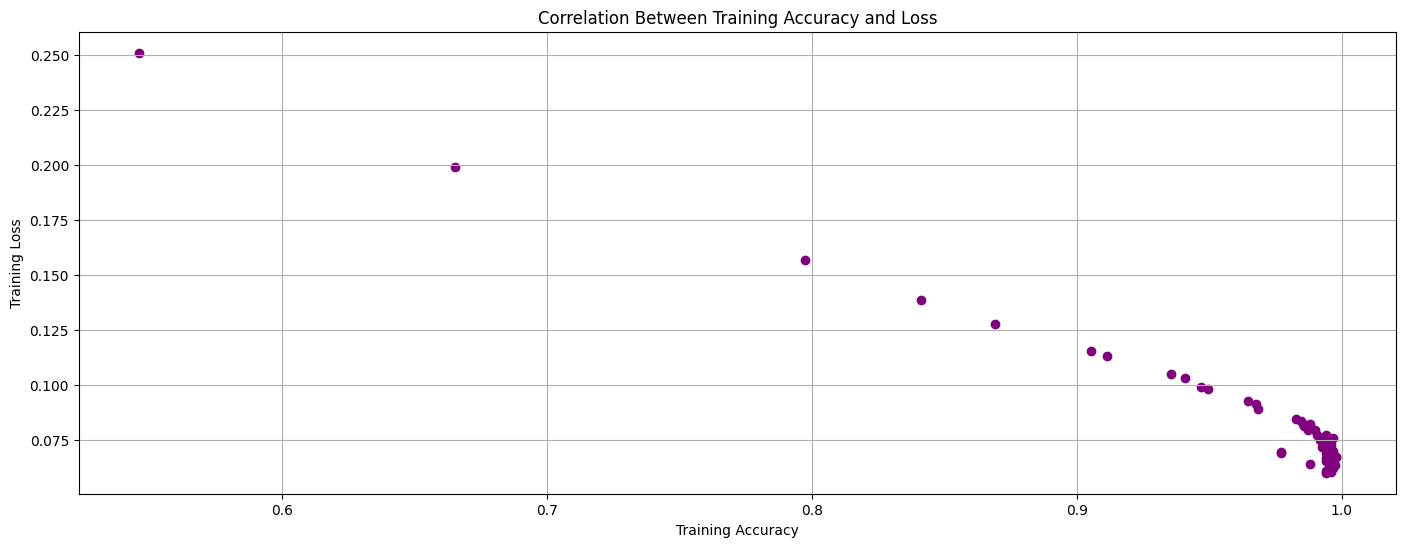

In [39]:
plt.figure(figsize=(17, 6))
plt.scatter(history_2['accuracy'], history_2['loss'], color='purple')
plt.title('Correlation Between Training Accuracy and Loss')
plt.xlabel('Training Accuracy')
plt.ylabel('Training Loss')
plt.grid(True)
plt.show()


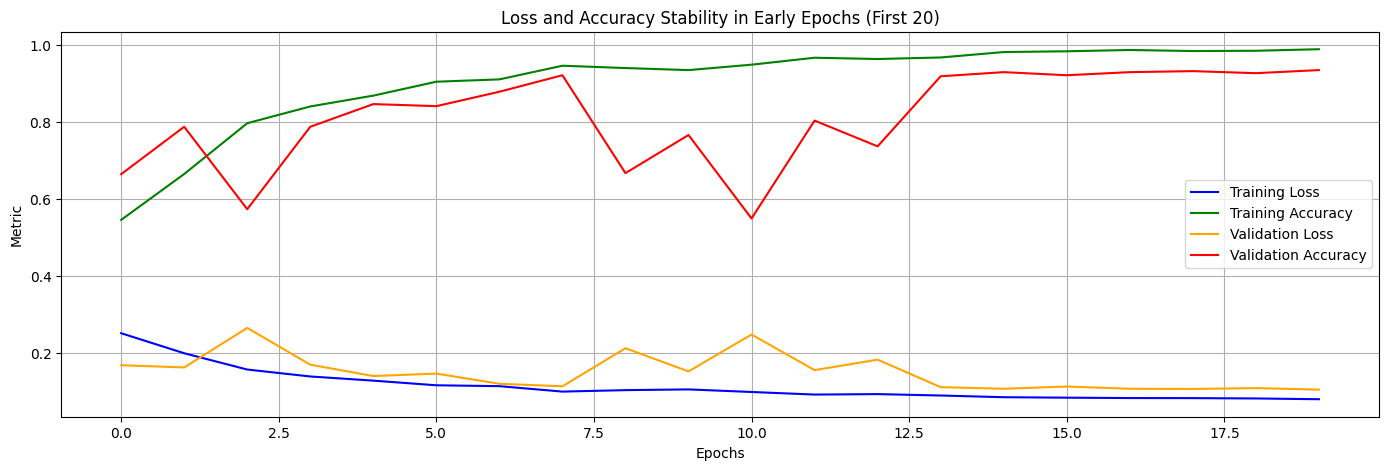

In [40]:
early_epochs = 20  # Adjust to check the initial epochs
plt.figure(figsize=(17, 5))
plt.plot(history_2['loss'][:early_epochs], label='Training Loss', color='blue')
plt.plot(history_2['accuracy'][:early_epochs], label='Training Accuracy', color='green')
plt.plot(history_2['val_loss'][:early_epochs], label='Validation Loss', color='orange')
plt.plot(history_2['val_accuracy'][:early_epochs], label='Validation Accuracy', color='red')
plt.title(f'Loss and Accuracy Stability in Early Epochs (First {early_epochs})')
plt.xlabel('Epochs')
plt.ylabel('Metric')
plt.legend()
plt.grid(True)
plt.show()


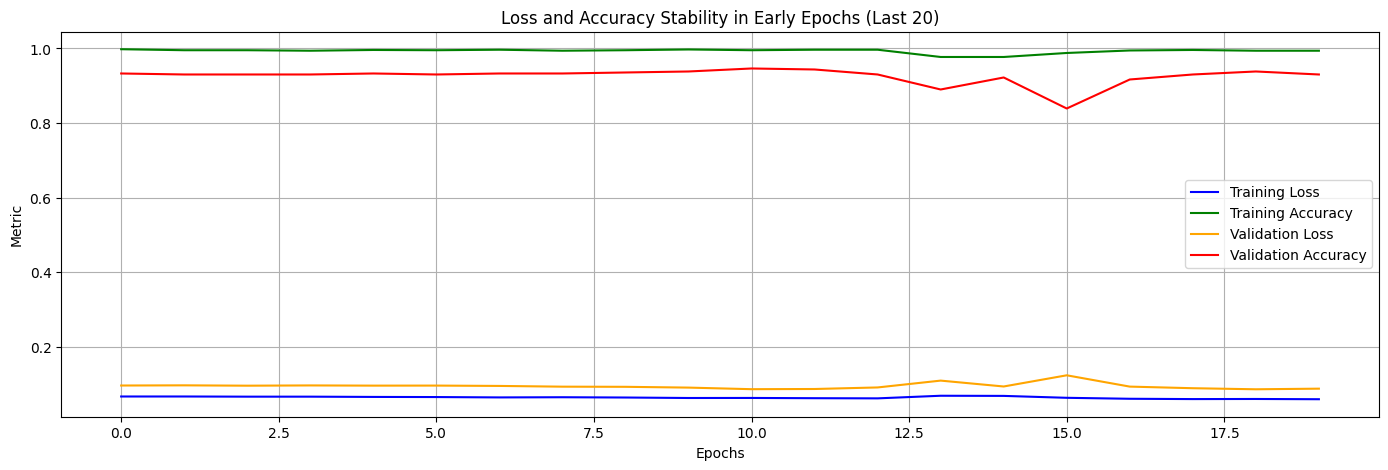

In [43]:
early_epochs = 20  # Adjust to check the initial epochs
plt.figure(figsize=(17, 5))
plt.plot(history_2['loss'][-early_epochs:], label='Training Loss', color='blue')
plt.plot(history_2['accuracy'][-early_epochs:], label='Training Accuracy', color='green')
plt.plot(history_2['val_loss'][-early_epochs:], label='Validation Loss', color='orange')
plt.plot(history_2['val_accuracy'][-early_epochs:], label='Validation Accuracy', color='red')
plt.title(f'Loss and Accuracy Stability in Early Epochs (Last {early_epochs})')
plt.xlabel('Epochs')
plt.ylabel('Metric')
plt.legend()
plt.grid(True)
plt.show()

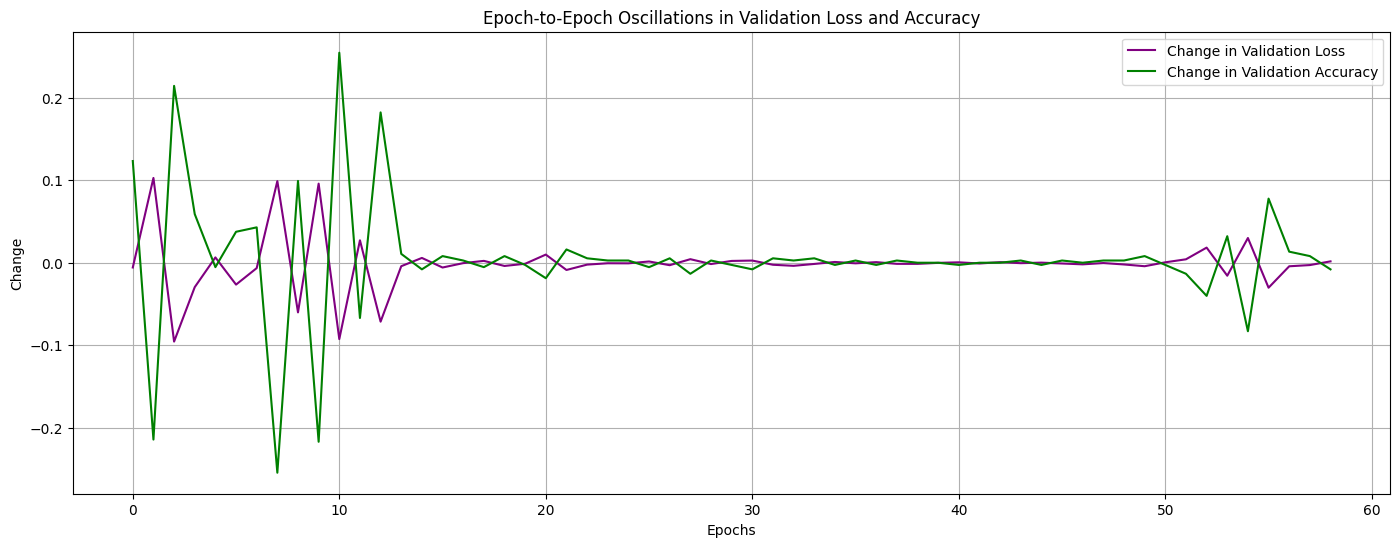

In [41]:
val_loss_change = np.diff(history_2['val_loss'])
val_accuracy_change = np.diff(history_2['val_accuracy'])

plt.figure(figsize=(17, 6))
plt.plot(val_loss_change, label='Change in Validation Loss', color='purple')
plt.plot(val_accuracy_change, label='Change in Validation Accuracy', color='green')
plt.title('Epoch-to-Epoch Oscillations in Validation Loss and Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Change')
plt.legend()
plt.grid(True)
plt.show()


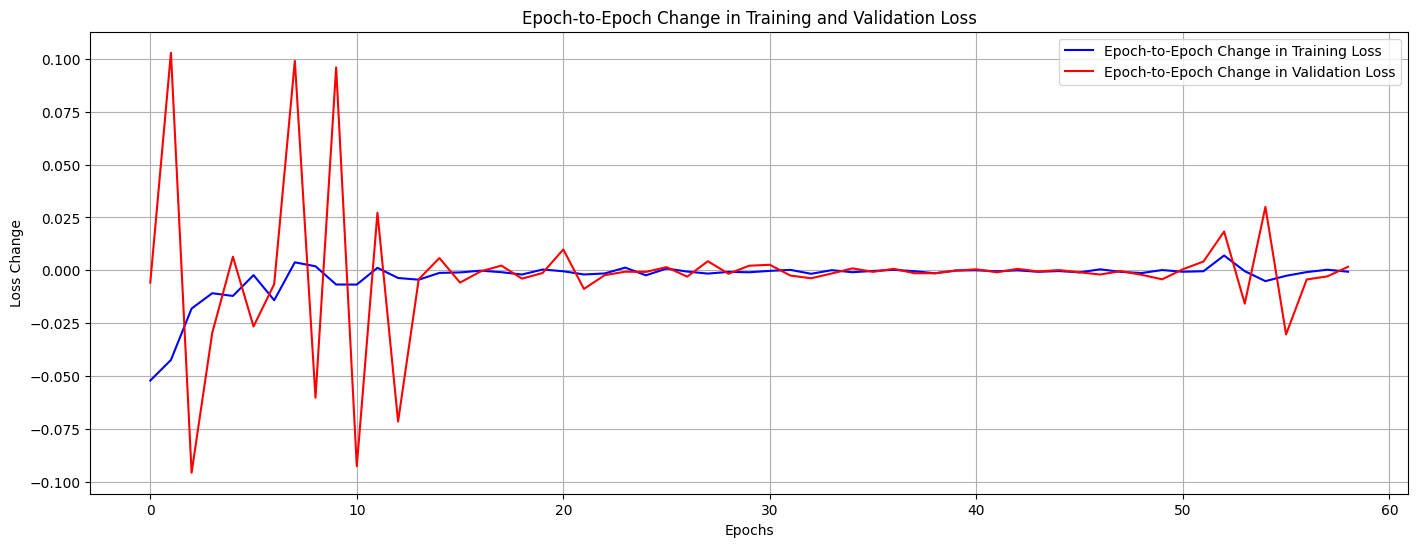

In [42]:
train_loss_change = np.diff(history_2['loss'])
val_loss_change = np.diff(history_2['val_loss'])

plt.figure(figsize=(17, 6))
plt.plot(train_loss_change, label='Epoch-to-Epoch Change in Training Loss', color='blue')
plt.plot(val_loss_change, label='Epoch-to-Epoch Change in Validation Loss', color='red')
plt.title('Epoch-to-Epoch Change in Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss Change')
plt.legend()
plt.grid(True)
plt.show()


### **Conclusion**

The performance analysis of this deepfake detection model reveals its effectiveness, robustness, and overall stability across training, validation, and test phases. Key aspects of its performance, including accuracy, ROC-AUC score, and generalization gap, all reflect a model well-suited for detecting deepfakes with high reliability.

### **1. Accuracy and Loss Metrics**

The model achieved a training accuracy of 99.66% and validation accuracy of 94.10%, indicating an impressive capability to generalize well across unseen data. The test accuracy of 93.74% further supports the model's reliability, as it performs consistently across various datasets. The gradual decline in both training and validation loss, with a final training loss of 0.0601 and validation loss of 0.0884, suggests efficient learning without signs of overfitting.

### **2. ROC-AUC and Precision-Recall Performance**

The ROC-AUC score of 0.9786 indicates that the model is proficient in distinguishing between genuine and deepfake inputs. This high AUC value reflects a low false-positive rate, crucial for applications in sensitive fields such as media, security, and public trust. Similarly, the precision-recall curve showed robust precision and recall values, confirming the model's accuracy in deepfake detection and suggesting it can perform well even in varied real-world scenarios.

### **3. Stability Over Epochs**

An analysis of accuracy and loss trends over epochs reveals a strong stability in the model’s performance. The model effectively minimizes the generalization gap, seen in the similar decline patterns between training and validation loss curves. With an optimal stopping point around Epoch 26, it achieves high accuracy while minimizing validation loss. This point, identified through early stopping, ensures the model neither overfits nor underfits, optimizing both performance and training efficiency.

### **4. Effective Learning Rate Adaptation**

The adaptive learning rate helped the model achieve faster convergence. The ReduceLROnPlateau callback reduced the learning rate at key points, preventing oscillations in loss and allowing fine-grained updates in later epochs. This mechanism contributed significantly to maintaining high performance while ensuring stability in both accuracy and loss metrics. The gradual reductions in the learning rate allowed the model to reach and sustain its optimal state effectively.

### **Final Thoughts**

Overall, this deepfake detection model demonstrates an outstanding ability to detect manipulated content with high accuracy, minimal misclassifications, and efficient training dynamics. Given its solid performance across all tested metrics, it stands as a reliable solution for deepfake detection and has the potential to play a valuable role in combatting digital misinformation. With minor optimizations, this model could be further strengthened to handle more complex deepfake scenarios, marking an essential step forward in the ongoing fight against digital content manipulation.